In [85]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    ROOT_DIR = '/content/drive/MyDrive/chest_xray_pneumonia_detection_minor_7th_sem/'
    platform = 'Google Colab'

except:
    ROOT_DIR = ''
    platform = 'Local machine'

dataset_path = f'{ROOT_DIR}Datasets/chest_xray/'

model_save_path = f'{ROOT_DIR}models'
result_save_path = f'{ROOT_DIR}results'
plot_save_path = f'{ROOT_DIR}plots'

print(f'Platform: {platform}')
dataset_path, model_save_path, result_save_path, plot_save_path

Platform: Local machine


('Datasets/chest_xray/', 'models', 'results', 'plots')

In [86]:
try:
    import torchmetrics
    print('TorchMetrics already installed.')
    
except:
    !pip install torchmetrics
    print('TorchMetrics installed.')


TorchMetrics already installed.
mlxtend already installed.


In [87]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import datasets, transforms, models
from torchmetrics import ConfusionMatrix, AUROC
from mlxtend.plotting import plot_confusion_matrix

import os
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pandas as pd
import random

from tqdm.auto import tqdm

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [89]:
BATCH_SIZE = 64 if platform == 'Google Colab' else 8
LR = 0.001
EPOCHS = 5
WANNA_TRAIN = False
WANNA_TEST = False
WANNA_SAVE = False

ANALYZE_DATASET = False
SAVE_PLOT_AS_PDF = False

USE_PARTIALLY_TRAINED = False
state_dict_name = 'PneumoniaDetector_2024-04-10_01-19-39.pth'

NORMALIZE = False

In [90]:
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor.clamp(-1, 1) * self.std + self.mean
    
class Identity:
    def __call__(self, tensor):
        return tensor

img_to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) if NORMALIZE else Identity()
])

tensor_to_img = transforms.Compose([
    UnNormalize(0.5, 0.5) if NORMALIZE else Identity(),
    transforms.ToPILImage()
])

In [91]:
def random_sample(dataset, classes):
    input, target = random.choice(dataset)

    image = tensor_to_img(input)
    display(image)
    print('Target:', classes[target])

def random_pred(dataset, model, classes):
    input, target = random.choice(dataset)

    input = input.to(device)
    image = tensor_to_img(input)
    display(image)

    model.eval()
    with torch.inference_mode():
        logits = model(input.unsqueeze(0)).squeeze()

    print(f'{"Raw Logits: ":30}{logits}') # raw logits
    probs = logits.softmax(0)
    print(f'{"Prediction Probabilities: ":30}{probs}') # prediction probabilities
    label = probs.argmax(0).item()
    print(f'{"Prediction Labels: ":30}{label}', end='\n\n') # prediction label
    
    print('Prediction:', classes[label])
    print('Target:', classes[target])

def dataset_analyzer(dataset, classes):
    freqs = [0] * len(classes)
    for X, y in dataset:
        freqs[y] += 1

    return {classes[i]: freqs[i] for i in range(len(classes))}

In [92]:
def harmonic_mean(a, b):
    if a + b == 0: return 0
    return 2 * a * b / (a + b)

def manage_nan(tensor):
    return tensor if not torch.isnan(tensor).item() else torch.tensor(0.0).to(device)

def confmat_to_accuracy(confmat): # micro
    num_classes = confmat.shape[0]

    correct_preds = 0
    for i in range(num_classes):
        correct_preds += confmat[i, i]
    all_preds = confmat.sum()

    acc = manage_nan(correct_preds / all_preds)

    return acc.item()

def confmat_to_precision(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[:, 1].sum()).item()

    prec = 0
    for i in range(num_classes):
        prec += manage_nan(confmat[i, i] / confmat[:, i].sum())
    prec /= num_classes

    return prec.item()

def confmat_to_recall(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return manage_nan(confmat[1, 1] / confmat[1].sum()).item()

    rec = 0
    for i in range(num_classes):
        rec += manage_nan(confmat[i, i] / confmat[i].sum())
    rec /= num_classes

    return rec.item()

def confmat_to_f1score(confmat): # macro
    num_classes = confmat.shape[0]

    if num_classes == 2:
        return harmonic_mean(confmat_to_precision(confmat), confmat_to_recall(confmat))

    f1 = 0
    for i in range(num_classes):
        prec = manage_nan(confmat[i, i] / confmat[:, i].sum())
        rec = manage_nan(confmat[i, i] / confmat[i].sum())

        f1 += harmonic_mean(prec, rec)
    f1 /= num_classes

    return f1.item()

In [93]:
dataset = datasets.ImageFolder(dataset_path, transform=img_to_tensor)

len(dataset), random.choice(dataset)

(5856,
 (tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
  
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]),
  0))

In [94]:
dataset.classes

['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL']

In [95]:
dataset.class_to_idx

{'NORMAL': 0, 'PNEUMONIA_BACTERIAL': 1, 'PNEUMONIA_VIRAL': 2}

In [96]:
dataset.imgs

[('Datasets/chest_xray/NORMAL\\IM-0001-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0003-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0005-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0006-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0007-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0009-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0010-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0011-0001-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0011-0001-0002.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0011-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0013-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0015-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0016-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0017-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0019-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0021-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0022-0001.jpeg', 0),
 ('Datasets/chest_xray/NORMAL\\IM-0023-0001.jpeg', 0),


In [97]:
dataset.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [98]:
dataset.transforms

StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

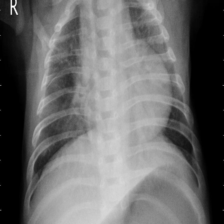

Target: PNEUMONIA_VIRAL


In [99]:
random_sample(dataset, classes=dataset.classes)

In [100]:
length = len(dataset)
split_ratio = (0.7, 0.1, 0.2)
train_size = int(length * split_ratio[0])
val_size = int(length * split_ratio[1])
test_size = length - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [101]:
if ANALYZE_DATASET:
    train_dataset_info = dataset_analyzer(train_dataset, classes=dataset.classes)
    val_dataset_info = dataset_analyzer(val_dataset, classes=dataset.classes)
    test_dataset_info = dataset_analyzer(test_dataset, classes=dataset.classes)

    df = pd.DataFrame([train_dataset_info, val_dataset_info, test_dataset_info], index=['Train', 'Validation', 'Test'])
    df_splitwise_perc = df.copy()
    df.loc['Total'] = df.sum()
    df_classwise_perc = df.copy()
    display(df)

    df_classwise_perc.loc['Train Class-wise %'] = df_classwise_perc.loc['Train'] / df_classwise_perc.loc['Train'].sum()
    df_classwise_perc.loc['Validation Class-wise %'] = df_classwise_perc.loc['Validation'] / df_classwise_perc.loc['Validation'].sum()
    df_classwise_perc.loc['Test Class-wise %'] = df_classwise_perc.loc['Test'] / df_classwise_perc.loc['Test'].sum()
    df_classwise_perc.loc['Total Class-wise %'] = df_classwise_perc.loc['Total'] / df_classwise_perc.loc['Total'].sum()
    df_classwise_perc = df_classwise_perc.drop(['Train', 'Validation', 'Test', 'Total'])
    display(df_classwise_perc)

    df_splitwise_perc['NORMAL Split-wise %'] = df_splitwise_perc['NORMAL'] / df_splitwise_perc['NORMAL'].sum()
    df_splitwise_perc['PNEUMONIA_BACTERIAL Split-wise %'] = df_splitwise_perc['PNEUMONIA_BACTERIAL'] / df_splitwise_perc['PNEUMONIA_BACTERIAL'].sum()
    df_splitwise_perc['PNEUMONIA_VIRAL Split-wise %'] = df_splitwise_perc['PNEUMONIA_VIRAL'] / df_splitwise_perc['PNEUMONIA_VIRAL'].sum()
    df_splitwise_perc = df_splitwise_perc.drop(['NORMAL', 'PNEUMONIA_BACTERIAL', 'PNEUMONIA_VIRAL'], axis=1)
    display(df_splitwise_perc)

In [102]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [103]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(513, 74, 147)

In [104]:
class PneumoniaDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.resnet = models.resnet18(weights='DEFAULT')
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 3) # in_features = 512

    def forward(self, x):
        return self.resnet(x)

In [105]:
model = PneumoniaDetector().to(device)

In [106]:
if USE_PARTIALLY_TRAINED:
    state_dict_loc = os.path.join(model_save_path, state_dict_name)
    state_dict = torch.load(state_dict_loc)
    model.load_state_dict(state_dict)

model.state_dict()

OrderedDict([('resnet.conv1.weight',
              tensor([[[[-2.7143e-02,  2.2098e-02, -3.8984e-02,  ...,  2.1138e-01,
                          1.2135e-01, -3.9064e-03],
                        [ 3.1062e-02,  1.0226e-01, -4.7912e-02,  ..., -2.0309e-01,
                         -6.9835e-02,  1.2275e-02],
                        [-6.9088e-02,  4.5631e-02,  3.9762e-01,  ...,  4.4804e-01,
                          1.0790e-01, -9.0575e-02],
                        ...,
                        [-7.0752e-02, -7.4364e-02, -1.3169e-01,  ..., -5.9072e-01,
                         -6.4343e-01, -3.9172e-01],
                        [ 4.5690e-02,  1.1352e-01,  1.3087e-01,  ...,  5.1366e-01,
                          5.4759e-01,  2.6609e-01],
                        [ 4.3516e-03,  1.1185e-01,  1.2264e-01,  ...,  3.5441e-03,
                          7.7911e-02,  1.8349e-02]],
              
                       [[-2.8121e-02,  1.6142e-03, -7.1815e-02,  ...,  1.8729e-01,
                         

In [107]:
model.eval()
with torch.inference_mode():
    pred = model(random.choice(train_dataset)[0].to(device).unsqueeze(0))
pred

tensor([[-13.7631,   9.1152,  -6.9856]], device='cuda:0')

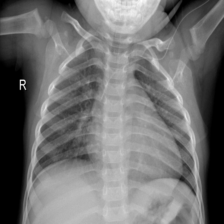

Raw Logits:                   tensor([10.2619, -7.0620, -3.9802], device='cuda:0')
Prediction Probabilities:     tensor([1.0000e+00, 2.9945e-08, 6.5275e-07], device='cuda:0')
Prediction Labels:            0

Prediction: NORMAL
Target: NORMAL


In [108]:
random_pred(train_dataset, model, classes=dataset.classes)

In [109]:
criterion = nn.CrossEntropyLoss()
confmat_metric = ConfusionMatrix(task='multiclass', num_classes=3).to(device)
auroc_metric = AUROC(task='multiclass', num_classes=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)

In [110]:
baseline_perf = {}

In [111]:
if WANNA_TRAIN and not baseline_perf:
    loss = 0
    auroc = 0
    master_confmat = torch.zeros(3, 3).to(device)

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(val_dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = logits.softmax(1)
            labels = probs.argmax(1)

            loss += criterion(logits, y).item()
            auroc += auroc_metric(probs, y).item()
            master_confmat += confmat_metric(labels, y)

    fig, ax = plot_confusion_matrix(
        conf_mat=master_confmat.cpu().numpy(),
        class_names=dataset.classes,
        colorbar=True
    )

    loss /= len(val_dataloader)
    auroc /= len(val_dataloader)
    acc = confmat_to_accuracy(master_confmat)
    prec = confmat_to_precision(master_confmat)
    rec = confmat_to_recall(master_confmat)
    f1 = confmat_to_f1score(master_confmat)

    print(f'Cross Entropy Loss: {loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}')
    baseline_perf['loss'] = loss
    baseline_perf['accuracy'] = acc
    baseline_perf['precision'] = prec
    baseline_perf['recall'] = rec
    baseline_perf['f1score'] = f1
    baseline_perf['auroc'] = auroc

In [112]:
baseline_perf

{}

In [113]:
train_losses = []
val_losses = []
accs = []
precs = []
recs = []
f1s = []
aurocs = []

In [114]:
train_losses, val_losses, accs, precs, recs, f1s, aurocs

([], [], [], [], [], [], [])

In [115]:
if WANNA_TRAIN:
    prev_size = len(train_losses)
    
    for epoch in tqdm(range(EPOCHS)):
        train_loss = 0
        val_loss = 0
        auroc = 0
        master_confmat = torch.zeros(3, 3).to(device)

        model.train()
        for X, y in tqdm(train_dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.inference_mode():
            for X, y in tqdm(val_dataloader):
                X, y = X.to(device), y.to(device)
                logits = model(X)
                probs = logits.softmax(1)
                labels = probs.argmax(1)

                val_loss += criterion(logits, y).item()
                auroc += auroc_metric(probs, y).item()
                master_confmat += confmat_metric(labels, y)

        fig, ax = plot_confusion_matrix(
            conf_mat=master_confmat.cpu().numpy(),
            class_names=dataset.classes,
            colorbar=True
        )

        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        auroc /= len(val_dataloader)
        acc = confmat_to_accuracy(master_confmat)
        prec = confmat_to_precision(master_confmat)
        rec = confmat_to_recall(master_confmat)
        f1 = confmat_to_f1score(master_confmat)

        print(f'Epoch: {epoch + prev_size}/{EPOCHS + prev_size} \nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}')
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
        aurocs.append(auroc)

In [116]:
if train_losses:
    plt.figure(figsize=(8, 10))
    plt.title(f'{model.__class__.__name__} Training/Validation Plot')
    plt.axis('off')

    # ========== (1) ==========

    plt.subplot(2, 1, 1)
    plt.plot([baseline_perf['loss']] + train_losses, label='Train Loss')
    plt.plot([baseline_perf['loss']] + val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')
    plt.legend(loc='best')
    # plt.ylim(-0.05, 1)

    # ========== (2) ==========

    plt.subplot(2, 1, 2)
    plt.plot([baseline_perf['accuracy']] + accs, label='Accuracy')
    plt.plot([baseline_perf['precision']] + precs, label='Precision')
    plt.plot([baseline_perf['recall']] + recs, label='Recall')
    plt.plot([baseline_perf['f1score']] + f1s, label='F1 Score')
    plt.plot([baseline_perf['auroc']] + aurocs, label='AUROC')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(True)
    plt.axhline(1, color='black')
    plt.axvline(0, color='black')
    plt.legend(loc='best')

    os.makedirs(plot_save_path, exist_ok=True)
    plot_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.{"pdf" if SAVE_PLOT_AS_PDF else "png"}'
    plt.savefig(os.path.join(plot_save_path, plot_file_name), bbox_inches='tight')

    plt.show()

  0%|          | 0/147 [00:00<?, ?it/s]

C:\Users\Kamal\AppData\Roaming\Python\Python311\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Cross Entropy Loss: 0.2339 
Accuracy: 94.71% 
Precision: 94.65% 
Recall: 94.31% 
F1 Score: 94.45% 
AUROC: 0.9264


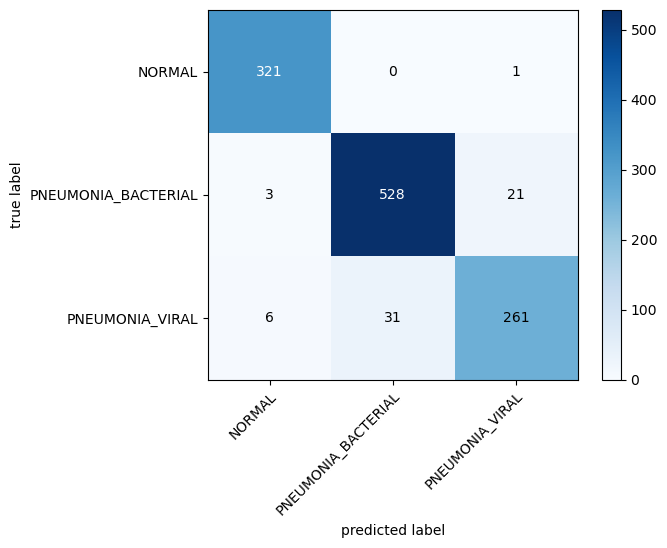

In [128]:
if WANNA_TEST:
    loss = 0
    auroc = 0
    master_confmat = torch.zeros(3, 3).to(device)

    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            probs = logits.softmax(1)
            labels = probs.argmax(1)

            loss += criterion(logits, y).item()
            auroc += auroc_metric(probs, y).item()
            master_confmat += confmat_metric(labels, y)

    fig, ax = plot_confusion_matrix(
        conf_mat=master_confmat.cpu().numpy(),
        class_names=dataset.classes,
        colorbar=True
    )
    
    loss /= len(test_dataloader)
    auroc /= len(test_dataloader)
    acc = confmat_to_accuracy(master_confmat)
    prec = confmat_to_precision(master_confmat)
    rec = confmat_to_recall(master_confmat)
    f1 = confmat_to_f1score(master_confmat)

    result = f'Cross Entropy Loss: {loss:.4f} \nAccuracy: {acc * 100:.2f}% | Precision: {prec * 100:.2f}% | Recall: {rec * 100:.2f}% | F1 Score: {f1 * 100:.2f}% \nAUROC: {auroc:.4f}'
    print(result)

    os.makedirs(result_save_path, exist_ok=True)
    result_file_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.txt'
    with open(os.path.join(result_save_path, result_file_name), 'w') as f:
        f.write(result)

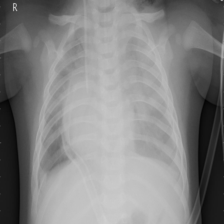

Raw Logits:                   tensor([-14.7191,   6.6949,  -4.0419], device='cuda:0')
Prediction Probabilities:     tensor([5.0124e-10, 9.9998e-01, 2.1731e-05], device='cuda:0')
Prediction Labels:            1

Prediction: PNEUMONIA_BACTERIAL
Target: PNEUMONIA_BACTERIAL


In [127]:
random_pred(test_dataset, model, classes=dataset.classes)

In [119]:
if WANNA_SAVE:
    os.makedirs(model_save_path, exist_ok=True)
    model_name = f'{model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.pth'
    torch.save(model.state_dict(), os.path.join(model_save_path, model_name))